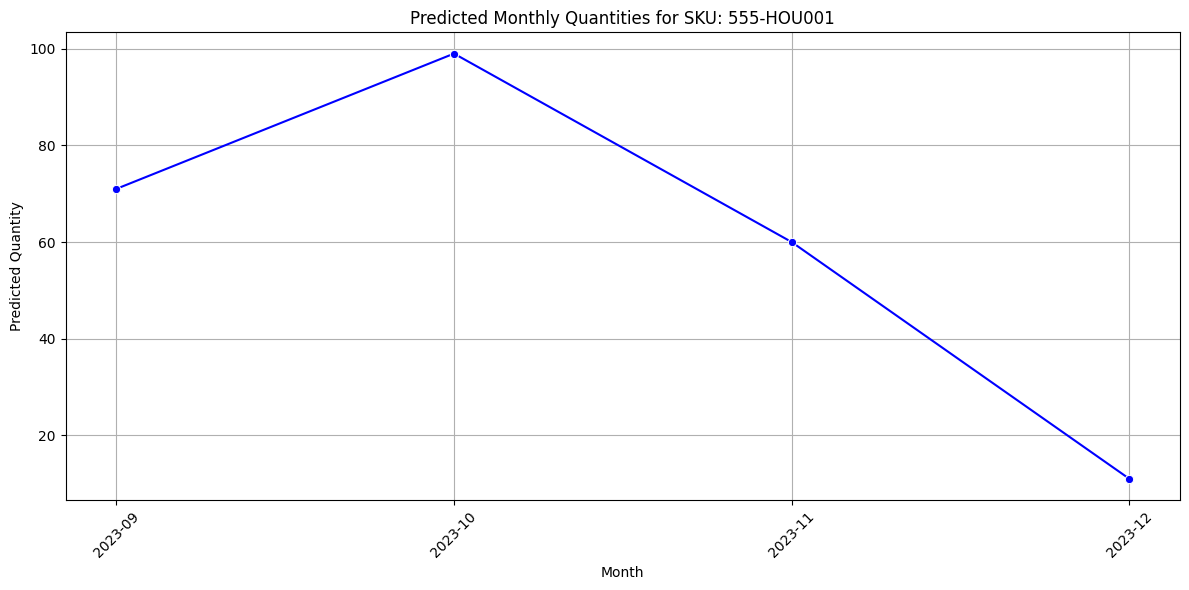

Displaying monthly forecast for sample SKU: 555-HOU001


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import DATA_PROCESSED

forecast_df = pd.read_csv(DATA_PROCESSED / "rolling_monthly_forecast.csv")
forecast_df['year_month'] = pd.PeriodIndex(forecast_df['year_month'], freq='M')

# Select a sample SKU (e.g., the first one in the forecast)
sample_sku_forecast = forecast_df['sku_id'].iloc[0]
sample_forecast_results = forecast_df[forecast_df['sku_id'] == sample_sku_forecast].sort_values('year_month')

plt.figure(figsize=(12, 6))
sns.lineplot(x=sample_forecast_results['year_month'].astype(str), y='predicted_qty', data=sample_forecast_results, marker='o', color='blue')

plt.title(f'Predicted Monthly Quantities for SKU: {sample_sku_forecast}')
plt.xlabel('Month')
plt.ylabel('Predicted Quantity')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Displaying monthly forecast for sample SKU: {sample_sku_forecast}")

Rolling-Forward Overall Mean Absolute Error: 72.80
Rolling-Forward Overall Mean Absolute Percentage Error: 50.58%


C:\Users\ras\AppData\Local\Temp\ipykernel_7388\4058527636.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right') # Rotate and align labels


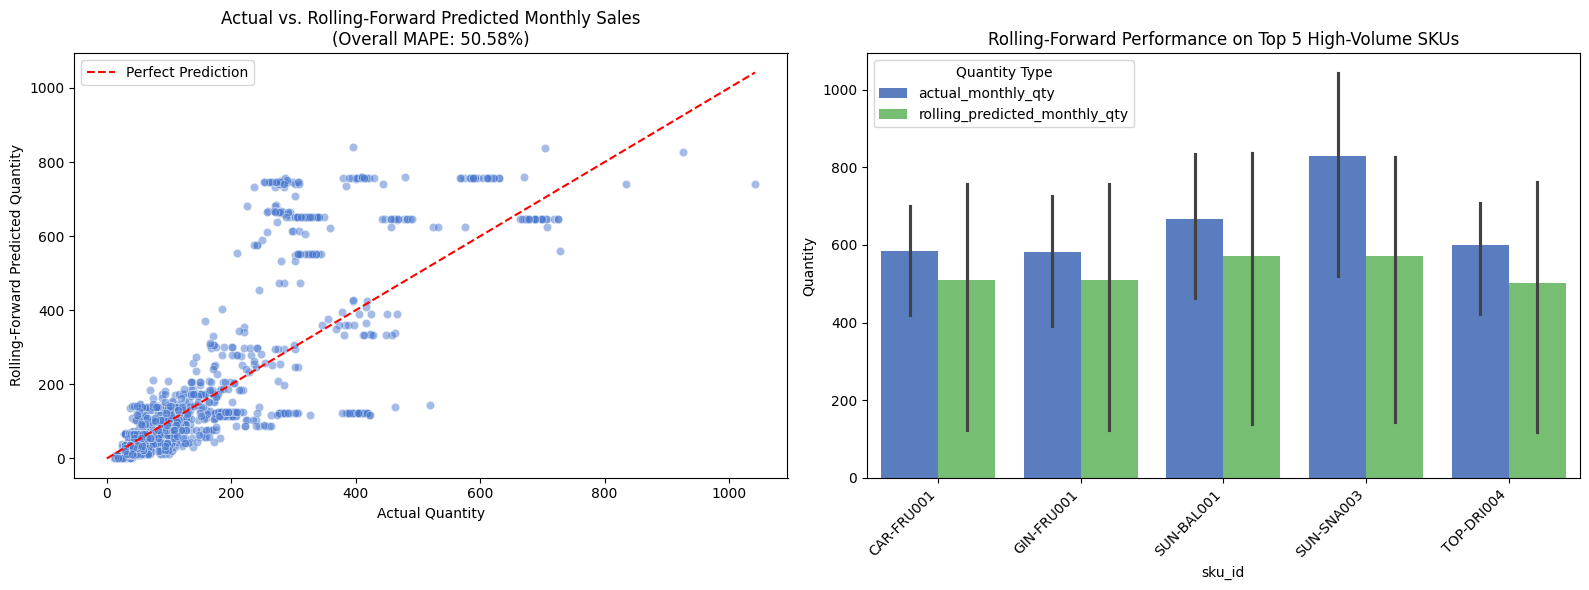

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import DATA_PROCESSED

# Load rolling-forward predictions
rolling_preds_df = pd.read_csv(DATA_PROCESSED / "rolling_monthly_forecast.csv")
rolling_preds_df['year_month'] = pd.PeriodIndex(rolling_preds_df['year_month'], freq='M')
rolling_preds_df = rolling_preds_df.rename(columns={'predicted_qty': 'rolling_predicted_monthly_qty'})

# Load actuals (and initial model predictions for comparison, if needed, but focus on actuals here)
actual_df = pd.read_csv(DATA_PROCESSED / "global_monthly_predictions_per_sku.csv")
actual_df['year_month'] = pd.PeriodIndex(actual_df['year_month'], freq='M')

# Merge the two dataframes to compare rolling-forward predictions with actuals
comparison_df = pd.merge(
    actual_df[['sku_id', 'year_month', 'actual_monthly_qty']],
    rolling_preds_df,
    on=['sku_id', 'year_month'],
    how='inner' # Ensure we only compare for common SKU-month pairs
)

# Calculate error metrics for the rolling-forward predictions
comparison_df['rolling_abs_error'] = (
    comparison_df['rolling_predicted_monthly_qty'] - comparison_df['actual_monthly_qty']
).abs()
comparison_df['rolling_pct_error'] = np.where(
    comparison_df['actual_monthly_qty'] > 0,
    comparison_df['rolling_abs_error'] / comparison_df['actual_monthly_qty'] * 100,
    0
)

# Calculate Global Metrics for the rolling-forward model
overall_mae_rolling = comparison_df['rolling_abs_error'].mean()
overall_mape_rolling = comparison_df['rolling_pct_error'].mean()

print(f"Rolling-Forward Overall Mean Absolute Error: {overall_mae_rolling:.2f}")
print(f"Rolling-Forward Overall Mean Absolute Percentage Error: {overall_mape_rolling:.2f}%")

# Plotting Setup
plt.style.use('seaborn-v0_8-muted')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- PLOT 1: Scatter Plot (Actual vs Rolling-Forward Predicted) ---
sns.scatterplot(
    data=comparison_df,
    x='actual_monthly_qty',
    y='rolling_predicted_monthly_qty',
    alpha=0.5,
    ax=ax1
)
# Add a 45-degree line (Perfect prediction line)
max_val = max(
    comparison_df['actual_monthly_qty'].max(),
    comparison_df['rolling_predicted_monthly_qty'].max()
)
ax1.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Prediction')

ax1.set_title(f"Actual vs. Rolling-Forward Predicted Monthly Sales\n(Overall MAPE: {overall_mape_rolling:.2f}%)")
ax1.set_xlabel("Actual Quantity")
ax1.set_ylabel("Rolling-Forward Predicted Quantity")
ax1.legend()

# --- PLOT 2: Top 5 SKUs Comparison (Rolling-Forward) ---
# Get the top 5 SKUs by total actual volume for the comparison period
top_skus_rolling = comparison_df.groupby('sku_id')['actual_monthly_qty'].sum().nlargest(5).index
top_df_rolling = comparison_df[comparison_df['sku_id'].isin(top_skus_rolling)]

# Melt the data for easier plotting with Seaborn
melted_df_rolling = top_df_rolling.melt(
    id_vars=['sku_id', 'year_month'],
    value_vars=['actual_monthly_qty', 'rolling_predicted_monthly_qty'],
    var_name='Type',
    value_name='Quantity'
)

sns.barplot(data=melted_df_rolling, x='sku_id', y='Quantity', hue='Type', ax=ax2)
ax2.set_title("Rolling-Forward Performance on Top 5 High-Volume SKUs")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right') # Rotate and align labels
ax2.legend(title='Quantity Type')

plt.tight_layout()
plt.savefig("rolling_forward_performance.png")
plt.show()

In [4]:
import pandas as pd
import numpy as np
from src.config import DATA_PROCESSED
# ----------------------------
# PATHS
# ----------------------------
TEST_PATH = DATA_PROCESSED / "test_data.csv"
ROLLING_DAILY_PATH = DATA_PROCESSED / "rolling_daily_forecast.csv"

# ----------------------------
# LOAD
# ----------------------------
test_df = pd.read_csv(TEST_PATH, parse_dates=["date"])
rolling_daily = pd.read_csv(ROLLING_DAILY_PATH, parse_dates=["date"])

# Keep only what we need
test_daily = test_df[["sku_id", "date", "target_qty"]].copy()

# ----------------------------
# MERGE
# ----------------------------
daily_compare = (
    rolling_daily
    .merge(
        test_daily,
        on=["sku_id", "date"],
        how="inner"
    )
)

# ----------------------------
# ERRORS
# ----------------------------
daily_compare["abs_error"] = np.abs(
    daily_compare["target_qty"] - daily_compare["predicted_qty"]
)

daily_compare["pct_error"] = (
    daily_compare["abs_error"] /
    np.maximum(daily_compare["target_qty"], 1)
) * 100

# ----------------------------
# METRICS
# ----------------------------
daily_mae = daily_compare["abs_error"].mean()
daily_wape = (
    daily_compare["abs_error"].sum() /
    daily_compare["target_qty"].sum()
) * 100

print("===== DAILY ROLLING vs ACTUAL =====")
print(f"MAE  : {daily_mae:.2f}")
print(f"WAPE : {daily_wape:.2f}%")

# ----------------------------
# SAVE
# ----------------------------
daily_compare.to_csv(
    DATA_PROCESSED / "rolling_daily_vs_actual.csv",
    index=False
)

print("Saved: rolling_daily_vs_actual.csv")


===== DAILY ROLLING vs ACTUAL =====
MAE  : 3.40
WAPE : 50.26%
Saved: rolling_daily_vs_actual.csv


In [5]:
# ----------------------------
# MONTHLY ACTUAL
# ----------------------------
test_df["year_month"] = test_df["date"].dt.to_period("M")

actual_monthly = (
    test_df
    .groupby(["sku_id", "year_month"])
    .agg(actual_qty=("target_qty", "sum"))
    .reset_index()
)

# ----------------------------
# LOAD ROLLING MONTHLY
# ----------------------------
rolling_monthly = pd.read_csv(
    DATA_PROCESSED / "rolling_monthly_forecast.csv"
)

rolling_monthly["year_month"] = rolling_monthly["year_month"].astype("period[M]")

# ----------------------------
# MERGE
# ----------------------------
monthly_compare = (
    rolling_monthly
    .merge(
        actual_monthly,
        on=["sku_id", "year_month"],
        how="inner"
    )
)

# ----------------------------
# ERRORS
# ----------------------------
monthly_compare["abs_error"] = np.abs(
    monthly_compare["actual_qty"] - monthly_compare["predicted_qty"]
)

monthly_compare["pct_error"] = (
    monthly_compare["abs_error"] /
    np.maximum(monthly_compare["actual_qty"], 1)
) * 100

# ----------------------------
# METRICS
# ----------------------------
monthly_mae = monthly_compare["abs_error"].mean()
monthly_wape = (
    monthly_compare["abs_error"].sum() /
    monthly_compare["actual_qty"].sum()
) * 100

print("\n===== MONTHLY ROLLING vs ACTUAL =====")
print(f"MAE  : {monthly_mae:.2f}")
print(f"WAPE : {monthly_wape:.2f}%")

# ----------------------------
# SAVE
# ----------------------------
monthly_compare.to_csv(
    DATA_PROCESSED / "rolling_monthly_vs_actual.csv",
    index=False
)

print("Saved: rolling_monthly_vs_actual.csv")



===== MONTHLY ROLLING vs ACTUAL =====
MAE  : 60.74
WAPE : 35.79%
Saved: rolling_monthly_vs_actual.csv


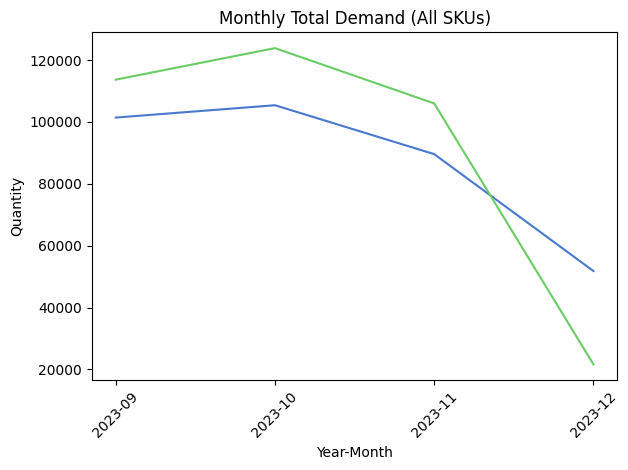

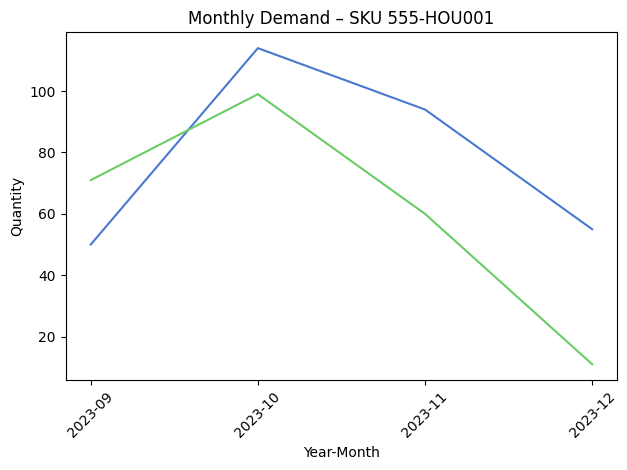

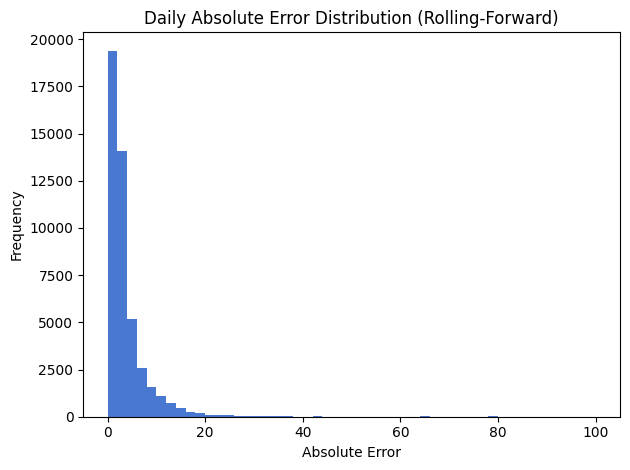

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# FIX THESE TWO PATHS ONLY
# ============================
DAILY_COMPARE_PATH = DATA_PROCESSED / "rolling_daily_vs_actual.csv"
MONTHLY_COMPARE_PATH = DATA_PROCESSED / "rolling_monthly_vs_actual.csv"

# ----------------------------
# LOAD DATA
# ----------------------------
daily_df = pd.read_csv(DAILY_COMPARE_PATH, parse_dates=["date"])
monthly_df = pd.read_csv(MONTHLY_COMPARE_PATH)

# ----------------------------
# 1) MONTHLY TOTAL (ALL SKUs)
# ----------------------------
monthly_total = (
    monthly_df
    .groupby("year_month")[["actual_qty", "predicted_qty"]]
    .sum()
    .reset_index()
)

monthly_total["year_month"] = monthly_total["year_month"].astype(str)

plt.figure()
plt.plot(monthly_total["year_month"], monthly_total["actual_qty"])
plt.plot(monthly_total["year_month"], monthly_total["predicted_qty"])
plt.xticks(rotation=45)
plt.title("Monthly Total Demand (All SKUs)")
plt.xlabel("Year-Month")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()

# ----------------------------
# 2) SINGLE SKU MONTHLY VIEW
# ----------------------------
example_sku = monthly_df["sku_id"].iloc[0]

sku_monthly = monthly_df[monthly_df["sku_id"] == example_sku].copy()
sku_monthly["year_month"] = sku_monthly["year_month"].astype(str)

plt.figure()
plt.plot(sku_monthly["year_month"], sku_monthly["actual_qty"])
plt.plot(sku_monthly["year_month"], sku_monthly["predicted_qty"])
plt.xticks(rotation=45)
plt.title(f"Monthly Demand – SKU {example_sku}")
plt.xlabel("Year-Month")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()

# ----------------------------
# 3) DAILY ERROR DISTRIBUTION
# ----------------------------
plt.figure()
plt.hist(daily_df["abs_error"], bins=50)
plt.title("Daily Absolute Error Distribution (Rolling-Forward)")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


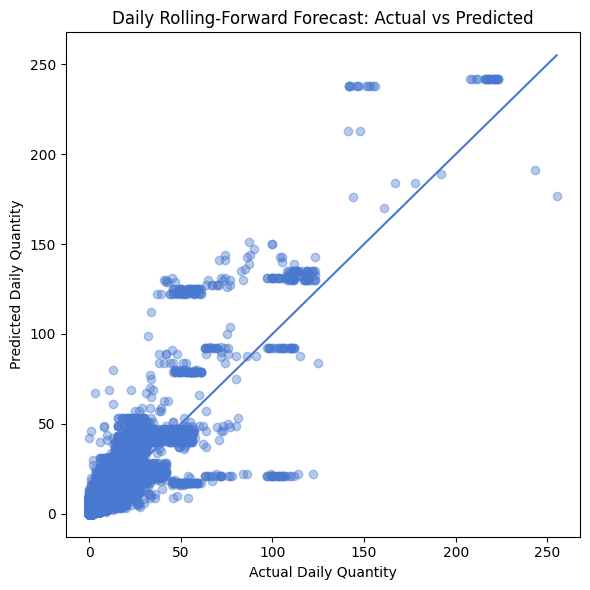

In [7]:
# Daily scatter plot
import pandas as pd
import matplotlib.pyplot as plt

# Load comparison file (adjust path if needed)
daily = pd.read_csv(
    DATA_PROCESSED / "rolling_daily_vs_actual.csv"
)

plt.figure(figsize=(6, 6))
plt.scatter(
    daily["target_qty"],
    daily["predicted_qty"],
    alpha=0.4
)

# 45-degree reference line (perfect predictions)
max_val = max(daily["target_qty"].max(), daily["predicted_qty"].max())
plt.plot([0, max_val], [0, max_val])

plt.xlabel("Actual Daily Quantity")
plt.ylabel("Predicted Daily Quantity")
plt.title("Daily Rolling-Forward Forecast: Actual vs Predicted")
plt.tight_layout()
plt.show()

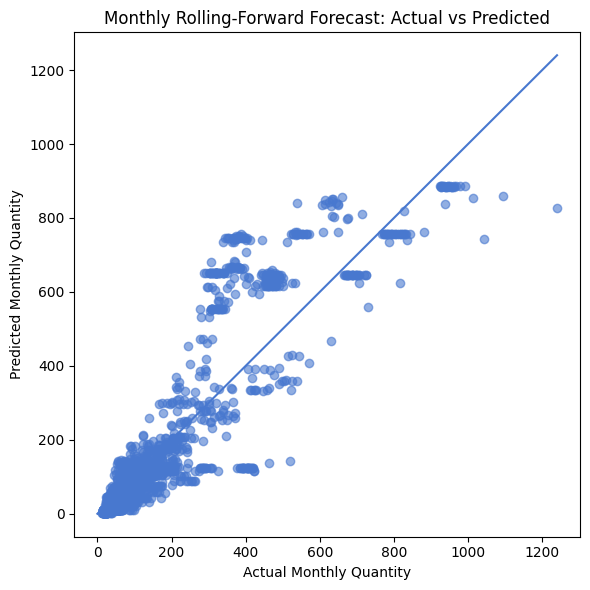

In [8]:
# Monthly scatter plot
monthly = pd.read_csv(
    DATA_PROCESSED / "rolling_monthly_vs_actual.csv"
)

plt.figure(figsize=(6, 6))
plt.scatter(
    monthly["actual_qty"],
    monthly["predicted_qty"],
    alpha=0.6
)

max_val = max(monthly["actual_qty"].max(), monthly["predicted_qty"].max())
plt.plot([0, max_val], [0, max_val])

plt.xlabel("Actual Monthly Quantity")
plt.ylabel("Predicted Monthly Quantity")
plt.title("Monthly Rolling-Forward Forecast: Actual vs Predicted")
plt.tight_layout()
plt.show()

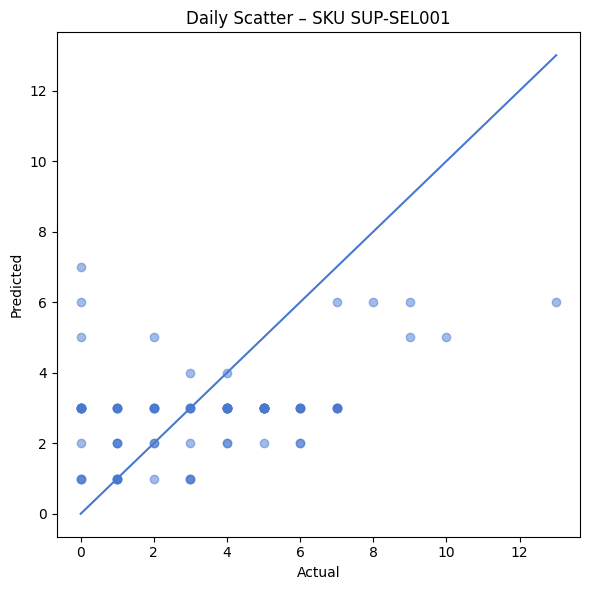

In [9]:
# Per SKU scatter plot
sku_id = daily["sku_id"].iloc[0]  # pick any SKU you want

sku_daily = daily[daily["sku_id"] == sku_id]

plt.figure(figsize=(6, 6))
plt.scatter(
    sku_daily["target_qty"],
    sku_daily["predicted_qty"],
    alpha=0.5
)

max_val = max(sku_daily["target_qty"].max(), sku_daily["predicted_qty"].max())
plt.plot([0, max_val], [0, max_val])

plt.title(f"Daily Scatter – SKU {sku_id}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()
